In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

#Getting the model and the weights of a CNN 

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), #Input chape of my data
                                include_top = False, #Ignore the fully connected layer at the top / Only convolutions
                                weights = None) #No weigths

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output #get this output with a lot of features

--2021-03-09 16:56:08--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.66.240, 142.250.67.16, 142.250.66.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.66.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  12.9MB/s    in 6.5s    

2021-03-09 16:56:16 (12.9 MB/s) - '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [2]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x) #Dropout for generalization                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) # Input to the pretrained model plus the new layers definition

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [3]:
# Cats vs Dogs 

!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-03-09 17:04:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.71.80, 216.58.199.80, 216.58.200.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.71.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: '/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  60.7MB/s    in 1.1s    

2021-03-09 17:04:22 (60.7 MB/s) - '/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
10/10 - 33s - loss: 0.8847 - accuracy: 0.7000 - val_loss: 0.2049 - val_accuracy: 0.9140
Epoch 2/20
10/10 - 21s - loss: 0.3309 - accuracy: 0.8400 - val_loss: 0.1806 - val_accuracy: 0.9240
Epoch 3/20
10/10 - 24s - loss: 0.2525 - accuracy: 0.9200 - val_loss: 0.1642 - val_accuracy: 0.9310
Epoch 4/20
10/10 - 28s - loss: 0.3537 - accuracy: 0.8550 - val_loss: 0.1823 - val_accuracy: 0.9230
Epoch 5/20
10/10 - 31s - loss: 0.2254 - accuracy: 0.9000 - val_loss: 0.2324 - val_accuracy: 0.9110
Epoch 6/20
10/10 - 33s - loss: 0.1871 - accuracy: 0.9250 - val_loss: 0.1089 - val_accuracy: 0.9470
Epoch 7/20
10/10 - 35s - loss: 0.1779 - accuracy: 0.9350 - val_loss: 0.1752 - val_accuracy: 0.9270
Epoch 8/20
10/10 - 31s - loss: 0.2313 - accuracy: 0.9100 - val_loss: 0.1216 - val_accuracy: 0.9530
Epoch 9/20
10/10 - 25s - loss: 0.3814 - accuracy: 0.8650 - val_loss: 0.1495 - val_accuracy: 0.9460
Epoch 10/20
10/10 - 15s - loss: 0.1971 - accuracy: 0.9200 - val_loss: 0.1514 - val_accuracy: 0.9440
Epoch 11/

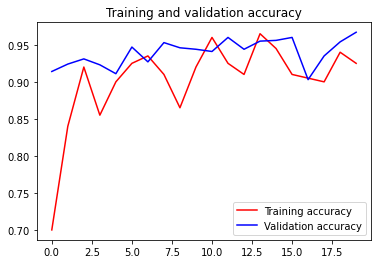

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()